<font size = "5"> **EELS_Tools:  [Spectroscopy](../4_EELS_Tools.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

# Analysis of EDS Spectra
<br>

[<img src=https://www.coeuscreativegroup.com/wp-content/uploads/2020/04/download-button.png, width=125>](https://raw.githubusercontent.com/pycroscopy/pyTEMlib/main/notebooks/Spectroscopy/EDS.ipynb) 

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/pycroscopy/pyTEMlib/blob/main/notebooks/Spectroscopy/EDS.ipynb)
    
part of 

<font size = "5"> **[pyTEMlib](https://pycroscopy.github.io/pyTEMlib/about.html)**</font>

a [pycroscopy](https://pycroscopy.github.io/pycroscopy/about.html) ecosystem package



Notebook by Gerd Duscher, 2025

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes

## Content
An Introduction into displaying and analyzing EDS spectrum images and spectra
This works also on Google Colab.


## Prerequesites

### Install pyTEMlib

If you have not done so in the [Introduction Notebook](_.ipynb), please test and install [pyTEMlib](https://github.com/gduscher/pyTEMlib) and other important packages with the code cell below.


In [1]:
import sys
import importlib.metadata

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version


# pyTEMlib setup ------------------
if test_package('pyTEMlib') < '0.2024.02.0':
    print('installing pyTEMlib')
   
    !{sys.executable} -m pip install pyTEMlib -q --upgrade

# ------------------------------
print('done')

done


**In Google Colab: Please restart runtime Ctrl+M**

### Loading of necessary libraries

Please note, that we only need to load the pyTEMlib library, which is based on sidpy Datsets.



In [2]:
%matplotlib widget
import numpy as np
import scipy

import matplotlib.pylab as plt
import sys

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

import pyTEMlib
# using  pyTEMlib.eds_tools, pyTEMlib.file_tools and pyTEMlib.eels_tools (for line definitions)

if 'google.colab' in sys.modules:
    drive.mount("/content/drive")

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)
__notebook__ = 'EDS_Spectrum_Analysis'
__notebook_version__ = '2025_08_06'

pyTEM version:  0.2025.07.0


## Open File

### Load File

Select a main dataset and any additional data like reference data and such.

In [3]:
fileWidget = pyTEMlib.file_tools.FileWidget()

### Select and Plot Dataset

Select a dataset from the drop down value and display it with the code cell below.

Here we sum the spectra of the 4 quadrants and define the detector parameter.

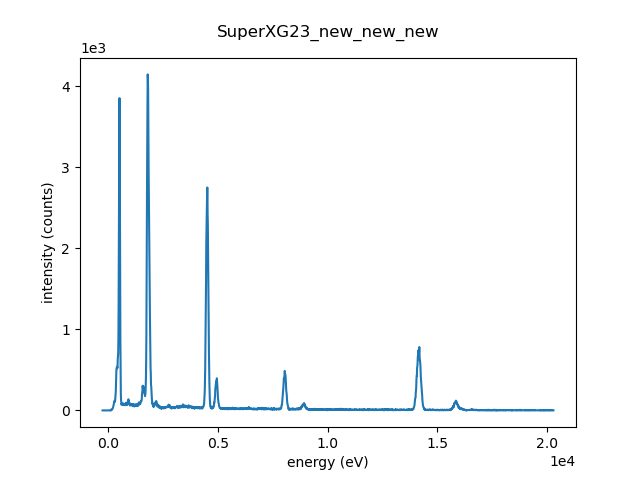

In [19]:
spectrum = None

for key in fileWidget.datasets.keys():
    if 'Super' in fileWidget.datasets[key].title:
        if spectrum == None:
            spectrum = fileWidget.datasets[key]
        else:
            spectrum += fileWidget.datasets[key]  
    else:
        spectrum = fileWidget.selected_dataset
spectrum.compute()

spectrum.data_type = 'spectrum'
spectrum.original_metadata = fileWidget.datasets[key].original_metadata.copy()

energy_scale = spectrum.get_spectral_dims(return_axis=True)[0].values 
start = np.searchsorted(spectrum.energy_scale.values, 100)
energy_scale = spectrum.energy_scale.values[start:]
detector_Efficiency= pyTEMlib.eds_tools.detector_response(spectrum)  # tags, spectrum.energy_scale.values[start:])
if 'start_energy' not in spectrum.metadata['EDS']['detector']:
    spectrum.metadata['EDS']['detector']['start_energy'] = 120
spectrum[:np.searchsorted(spectrum.energy_scale.values,spectrum.metadata['EDS']['detector']['start_energy'])] = 0.
spectrum.metadata['EDS']['detector']['detector_efficiency']  = detector_Efficiency
view = spectrum.plot()



In [20]:
spectrum.metadata['EDS'] 

{'detector': {'layers': {13: {'thickness': 5e-08, 'Z': 13, 'element': 'Al'}},
  'SiDeadThickness': 1.3e-07,
  'SiLiveThickness': 0.05,
  'detector_area': 2.9999999999999997e-05,
  'energy_resolution': 125,
  'start_energy': 120,
  'start_channel': np.int64(37),
  'ElevationAngle': 0.31415927,
  'AzimuthAngle': 3.9269908169872414,
  'RealTime': 26.2338126,
  'LiveTime': 25.20496870466589,
  'detector_efficiency': array([0.        , 0.        , 0.        , ..., 0.99984687, 0.99984708,
         0.99984728])}}

## Find Elements 

C:\Users\gduscher\AppData\Local\anaconda3\envs\py313\Lib\site-packages\dask\array\core.py:1758: FutureWarning: The `numpy.argsort` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


['Sr', 'O', 'Ti', 'Cu', 'O']


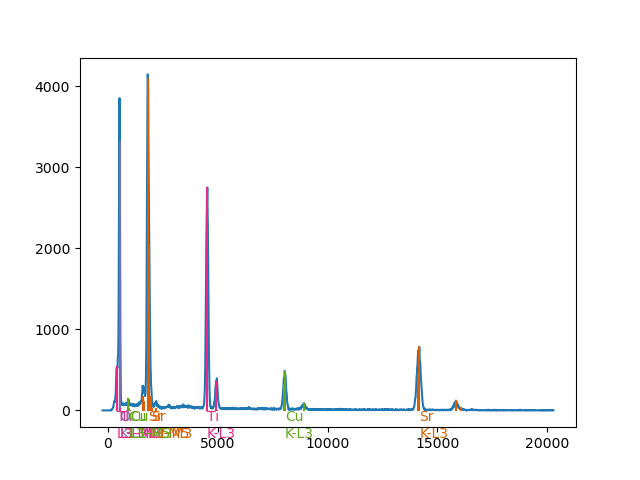

In [21]:
# --------Input -----------
minimum_number_of_peaks = 10
# --------------------------
minor_peaks = pyTEMlib.eds_tools.detect_peaks(spectrum, minimum_number_of_peaks=minimum_number_of_peaks)

keys = list(spectrum.metadata['EDS'].keys())
for key in keys:
    if len(key) < 3:
        del spectrum.metadata['EDS'][key]

elements = pyTEMlib.eds_tools.find_elements(spectrum, minor_peaks)

elements += ['O']
print(elements)
spectrum.metadata['EDS'].update(pyTEMlib.eds_tools.get_x_ray_lines(spectrum, elements))
plt.figure()
plt.plot(spectrum.energy_scale,spectrum, label = 'spectrum')
pyTEMlib.eds_tools.plot_lines(spectrum.metadata['EDS'], plt.gca())


## Quantify

C:\Users\gduscher\AppData\Local\anaconda3\envs\py313\Lib\site-packages\pyTEMlib\eels_tools.py:1625: RuntimeWarning: Number of calls to function has reached maxfev = 2000.
  [p, _] = leastsq(bgdfit, p0, args=(y, x), maxfev=2000)


Sr: 21.82 at%  50.38 wt%
O : 58.35 at%  24.60 wt%
Ti: 19.83 at%  25.01 wt%
excluded from quantification  ['Cu']


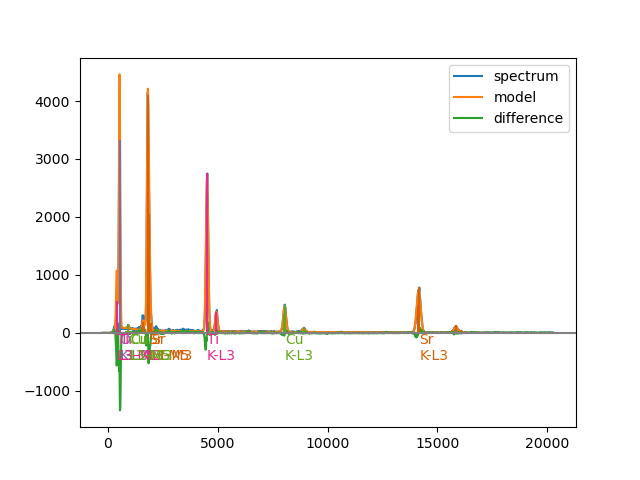

In [22]:
# ------- Input --------
mask = ['Cu']
# ----------------------
peaks, pp = pyTEMlib.eds_tools.fit_model(spectrum, elements, use_detector_efficiency=True)
model = pyTEMlib.eds_tools.get_model(spectrum)
k_factors = pyTEMlib.eds_tools.load_k_factors()

pyTEMlib.eds_tools.quantify_EDS(spectrum, k_factors=k_factors, mask=mask) 

plt.figure()
plt.plot(spectrum.energy_scale, spectrum, label='spectrum')
plt.plot(spectrum.energy_scale, model, label='model')
plt.plot(spectrum.energy_scale, spectrum-model, label='difference')

pyTEMlib.eds_tools.plot_lines(spectrum.metadata['EDS'], plt.gca())
plt.axhline(y=0, xmin=0, xmax=1, color='gray')
plt.legend()

## Summary

Using the k-factors of Spectra300, a model of the complete spectrum is used for quantification.

## Appendix
### Background
The determined background used for the model-based quantification is based on the detector effciency.

Note:

The detector efficiency is also used for the quantification model.


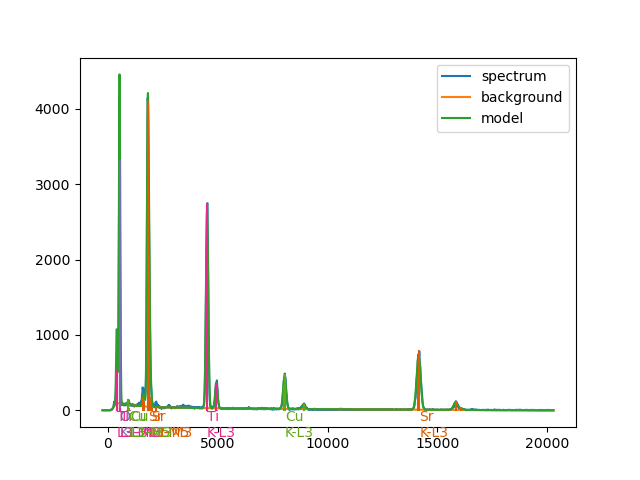

In [24]:
detector_efficiency = pyTEMlib.eds_tools.detector_response(spectrum)  # tags, spectrum.energy_scale.values[start:])
energy_scale = spectrum.energy_scale.values
start = np.searchsorted(energy_scale, 50)
E_0= spectrum.metadata['experiment']['acceleration_voltage']

bremsstrahlung = detector_efficiency * (pp[-3] + pp[-2] * (E_0 - energy_scale) / energy_scale + pp[-1] * (E_0 - energy_scale) ** 2 / energy_scale)
bremsstrahlung[:start] = 0.

plt.figure()
plt.plot(spectrum.energy_scale, spectrum, label='spectrum')
plt.plot(spectrum.energy_scale, bremsstrahlung, label='background')
plt.plot(spectrum.energy_scale, model, label='model')
pyTEMlib.eds_tools.plot_lines(spectrum.metadata['EDS'], plt.gca())
plt.legend()